In [4]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import datetime
import pytz
import tzlocal
import h5py

import seaborn as sns

import uproot #This is uproot4 (only reading so far)
import uproot3 #This is needed to write TTrees in rootfiles untill it is not sopported in uproot4

%matplotlib inline

#uncomment the following if using jupyter notebook to get interactive plots (zooming).... sometimes it doesn't work
%matplotlib notebook 

In [25]:
%matplotlib inline


In [5]:
#Select the filename and the specific measurement (InfluxDB jargon) time series
filename = 'data/SC_data_AllRun.h5'

In [6]:
#Check the measurements present in the file
with h5py.File(filename,'r') as datafile:
    print(*list(datafile.keys()))

LAr_Level LAr_Level_pF LN2_Level LN2_Level_pF PLC flow temp


In [7]:
#Load into a dataframe the selected InfluxDB measurement and visualise how the data is organised in the dataframe
measurement = 'PLC'
PLC_df = pd.read_hdf(filename, key=measurement)
PLC_df.head(5)

,device,value
UTC,,
2021-06-13 22:00:00.633846+00:00,TT1_LAr_Filter_Corr,29.789117
2021-06-13 22:00:00.640968+00:00,TT2_LAr_Filter_Corr,32.108545
2021-06-13 22:00:00.648245+00:00,TT3_LAr_Filter_Corr,29.163477
2021-06-13 22:00:00.655310+00:00,TT4_LAr_Filter_Corr,28.125879
2021-06-13 22:00:00.662290+00:00,TT5_LN2_Cryo,28.492090


In [9]:
#Group the measurements by the device
PLC_dev_gr = PLC_df.groupby('device')

In [10]:
#Check how many measurements are present for each device
PLC_dev_gr.size().to_frame().rename(columns={0:'Series size'})

,Series size
device,
DPM1,698753
FT1_Flow,698753
GFM1_gN2,698753
GFM2_gAr,698753
GFM3_gH2,698753
LAr_Level,698753
LN2_Level,698753
LN2_Level_SP,698753
PT1_LDetek_Carrier,698753


Some devices have longer time series than others. This might be sign of packets lost and/or of random delays between devices or between the consecutive observations of the same device.  

Next step is to check the times of the single devices, after making a data frame for each of them, as function of their event number.

In [11]:
#Make a dictionary with the splitted dataframes for each device
#They will be separate time series now
devs_dfs = {}
for name, gr in PLC_dev_gr:
    devs_dfs[name] = gr[['value']].copy()
    #Move the UTC time from index to column for working better with it
    devs_dfs[name].reset_index(inplace=True) 
    

In [8]:
#List all the devices that I can filter for
list(devs_dfs.keys())

<IPython.core.display.Javascript object>


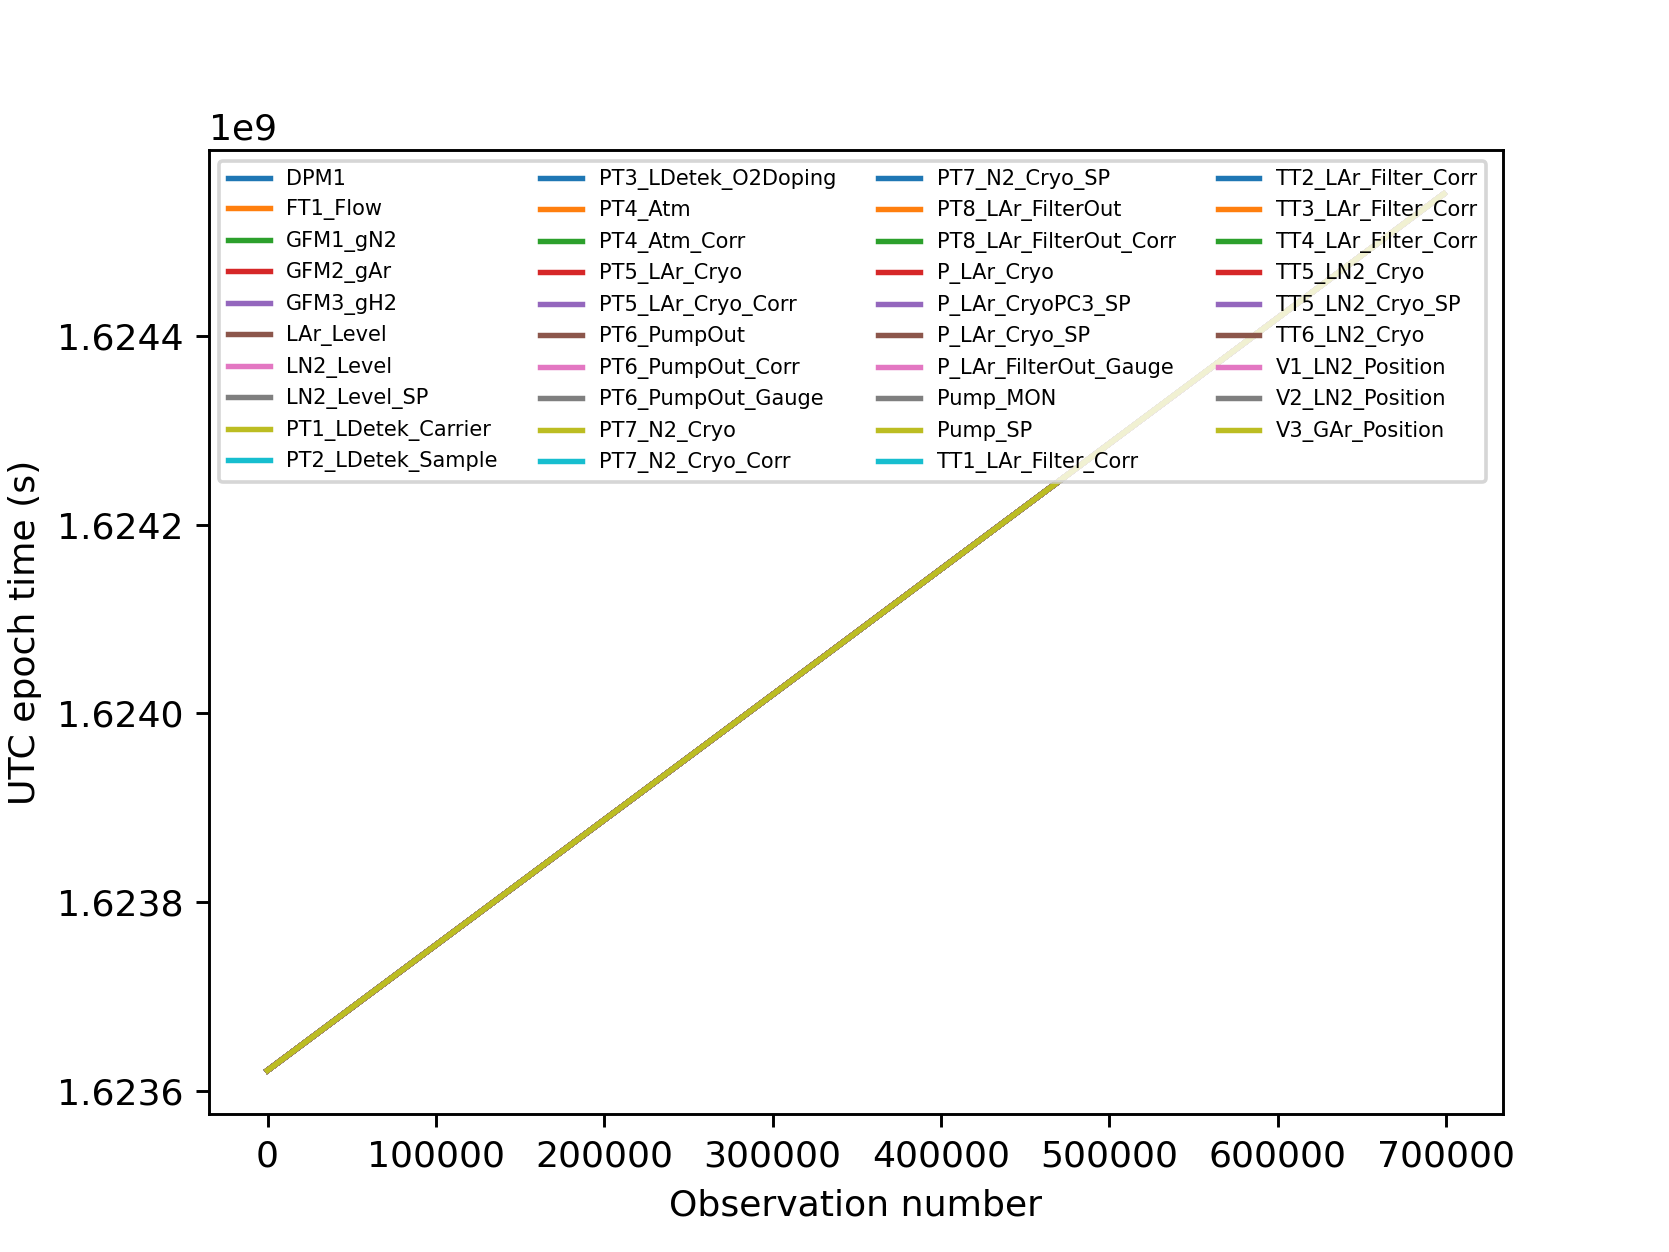

In [25]:
#Plot the times for each of the devices to figure out whether they coincide within the second
fig, axs = plt.subplots()

for dev in devs_dfs:
    (devs_dfs[dev]['UTC'].astype(np.int64)/10**9).plot(ax=axs, label=dev)
axs.set_xlabel('Observation number')
axs.set_ylabel('UTC epoch time (s)')
axs.legend(fontsize='xx-small', ncol=4, loc='upper left')
fig.show()

From the plot above there isn't so much that can be seen. Maybe better to plot, for each observation, the $\Delta t$ between the UTC of an instrument and that of the one with minimum UTC time.

In [12]:
#As not all the time series have the same length get the shortest 
min_size = PLC_dev_gr.size().to_frame().rename(columns={0:'Series size'})['Series size'].min()

utc_delta_arr = np.zeros( (min_size,len(devs_dfs)) )



#Fill the table by columns (device)
for iDev in range(len(devs_dfs)):
    dev = list(devs_dfs)[iDev]
    arr = (devs_dfs[dev]['UTC'].astype(np.int64)/10**9).iloc[:min_size].to_numpy()
    utc_delta_arr[:,iDev] = arr.reshape((-1,min_size))
#

utc_epochs_arr = utc_delta_arr.copy() #keep this for later use
utc_epocs_df = pd.DataFrame(data=utc_epochs_arr, columns=list(devs_dfs))


# For each row (observation) subtract the minimum UTC across the devices
utc_times_arr = np.zeros( (min_size,len(devs_dfs)) ) #This I keep 
for iRow in range(utc_delta_arr.shape[0]):
    utc_delta_arr[iRow,:] = utc_delta_arr[iRow,:] - np.min(utc_delta_arr[iRow,:])
    

utc_delta_df = pd.DataFrame(data=utc_delta_arr, columns=list(devs_dfs))
utc_delta_df.head(5)

,DPM1,FT1_Flow,GFM1_gN2,GFM2_gAr,GFM3_gH2,LAr_Level,LN2_Level,LN2_Level_SP,PT1_LDetek_Carrier,PT2_LDetek_Sample,...,TT1_LAr_Filter_Corr,TT2_LAr_Filter_Corr,TT3_LAr_Filter_Corr,TT4_LAr_Filter_Corr,TT5_LN2_Cryo,TT5_LN2_Cryo_SP,TT6_LN2_Cryo,V1_LN2_Position,V2_LN2_Position,V3_GAr_Position
0,0.288364,0.224842,0.269071,0.275686,0.281572,0.244475,0.238487,0.232618,0.078063,0.085313,...,0.0,0.007122,0.014399,0.021464,0.028444,0.063757,0.070921,0.251355,0.257161,0.263227
1,0.279248,0.216461,0.260784,0.266911,0.273079,0.235260,0.228255,0.222303,0.084933,0.091920,...,0.0,0.011439,0.022499,0.029810,0.036436,0.071220,0.078123,0.242072,0.247979,0.254670
2,0.311537,0.241948,0.289762,0.296199,0.303560,0.261051,0.254502,0.248125,0.073891,0.080114,...,0.0,0.009814,0.017156,0.023938,0.030388,0.061296,0.067724,0.267832,0.274254,0.283436
3,0.299724,0.229409,0.278722,0.285485,0.292566,0.250081,0.243227,0.236289,0.084445,0.090707,...,0.0,0.006238,0.014825,0.022235,0.031010,0.071121,0.077459,0.256890,0.263792,0.271949
4,0.270735,0.209610,0.253038,0.259026,0.264760,0.229130,0.222869,0.216343,0.074422,0.081034,...,0.0,0.007127,0.014179,0.020788,0.027581,0.059499,0.065888,0.235157,0.241133,0.247268


In [12]:
utc_epocs_df.head(5)

,DPM1,FT1_Flow,GFM1_gN2,GFM2_gAr,GFM3_gH2,LAr_Level,LN2_Level,LN2_Level_SP,PT1_LDetek_Carrier,PT2_LDetek_Sample,...,TT1_LAr_Filter_Corr,TT2_LAr_Filter_Corr,TT3_LAr_Filter_Corr,TT4_LAr_Filter_Corr,TT5_LN2_Cryo,TT5_LN2_Cryo_SP,TT6_LN2_Cryo,V1_LN2_Position,V2_LN2_Position,V3_GAr_Position
0,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,...,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09
1,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,...,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09
2,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,...,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09
3,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,...,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09
4,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,...,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09


<IPython.core.display.Javascript object>


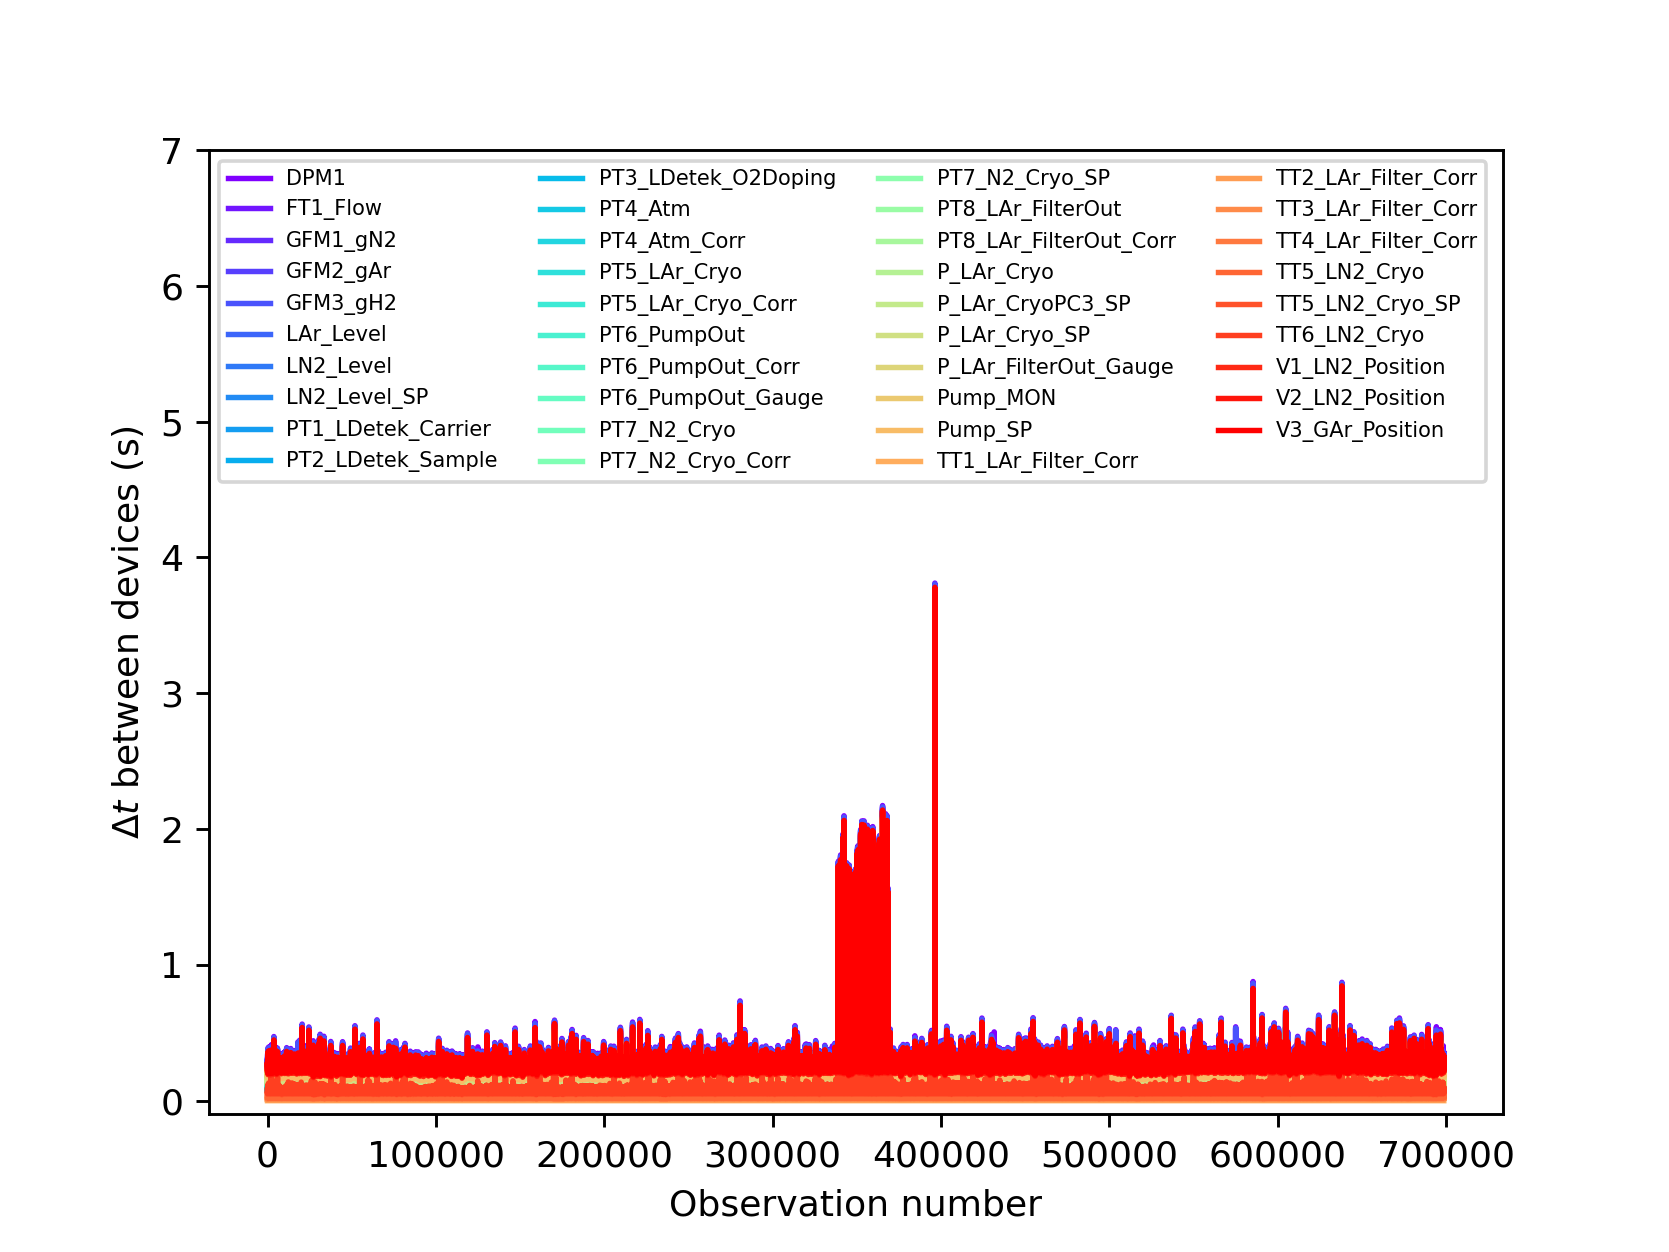

In [23]:
fig, axs = plt.subplots()

colr_map=matplotlib.cm.get_cmap('rainbow',len(list(utc_delta_df)))

for iDev in range(len(list(utc_delta_df))):
    dev = list(utc_delta_df)[iDev]
    axs.plot(utc_delta_df[dev], label=dev, color=colr_map(iDev))
#
axs.set_xlabel('Observation number')
axs.set_ylabel('$\Delta t$ between devices (s)')
axs.set_ylim(-0.1,7)
axs.legend(fontsize='xx-small', ncol=4, loc='upper left')
fig.show()

Checking the time series of the devices relative delays (zooming into them - run the cell for it!), especially where the are the spikes, it seems that the ordering between the instruments dealay for the same observation is always the same. In such a case I could just get the median or minimum UTC time. And assign it to each mesurement. To understand better if this is the case I can plot together histograms of all the instruments with all the ranks of the their time delays over the observations.

In [13]:
#Transform the observation times in ranks to figure out if the oprdering is always the same
utc_rank_arr = np.zeros( utc_epochs_arr.shape, dtype=int )

for iRow in range(utc_epochs_arr.shape[0]):
    utcs_arr = utc_epochs_arr[iRow,:]
    sort_arr = utcs_arr.argsort()
    ranks_arr = np.empty_like(sort_arr)
    ranks_arr[sort_arr] = np.arange(len(utcs_arr))
    utc_rank_arr[iRow,:] = ranks_arr
#
delays_ranks_df = pd.DataFrame(data=utc_rank_arr, columns=list(devs_dfs))
delays_ranks_df.head(5).T

,0,1,2,3,4
DPM1,38,38,38,38,38
FT1_Flow,28,28,28,28,28
GFM1_gN2,35,35,35,35,35
GFM2_gAr,36,36,36,36,36
GFM3_gH2,37,37,37,37,37
LAr_Level,31,31,31,31,31
LN2_Level,30,30,30,30,30
LN2_Level_SP,29,29,29,29,29
PT1_LDetek_Carrier,7,7,7,7,7
PT2_LDetek_Sample,8,8,8,8,8


In [17]:
delays_ranks_df.head(5).T

,0,1,2,3,4
DPM1,38,38,38,38,38
FT1_Flow,28,28,28,28,28
GFM1_gN2,35,35,35,35,35
GFM2_gAr,36,36,36,36,36
GFM3_gH2,37,37,37,37,37
LAr_Level,31,31,31,31,31
LN2_Level,30,30,30,30,30
LN2_Level_SP,29,29,29,29,29
PT1_LDetek_Carrier,7,7,7,7,7
PT2_LDetek_Sample,8,8,8,8,8


<IPython.core.display.Javascript object>


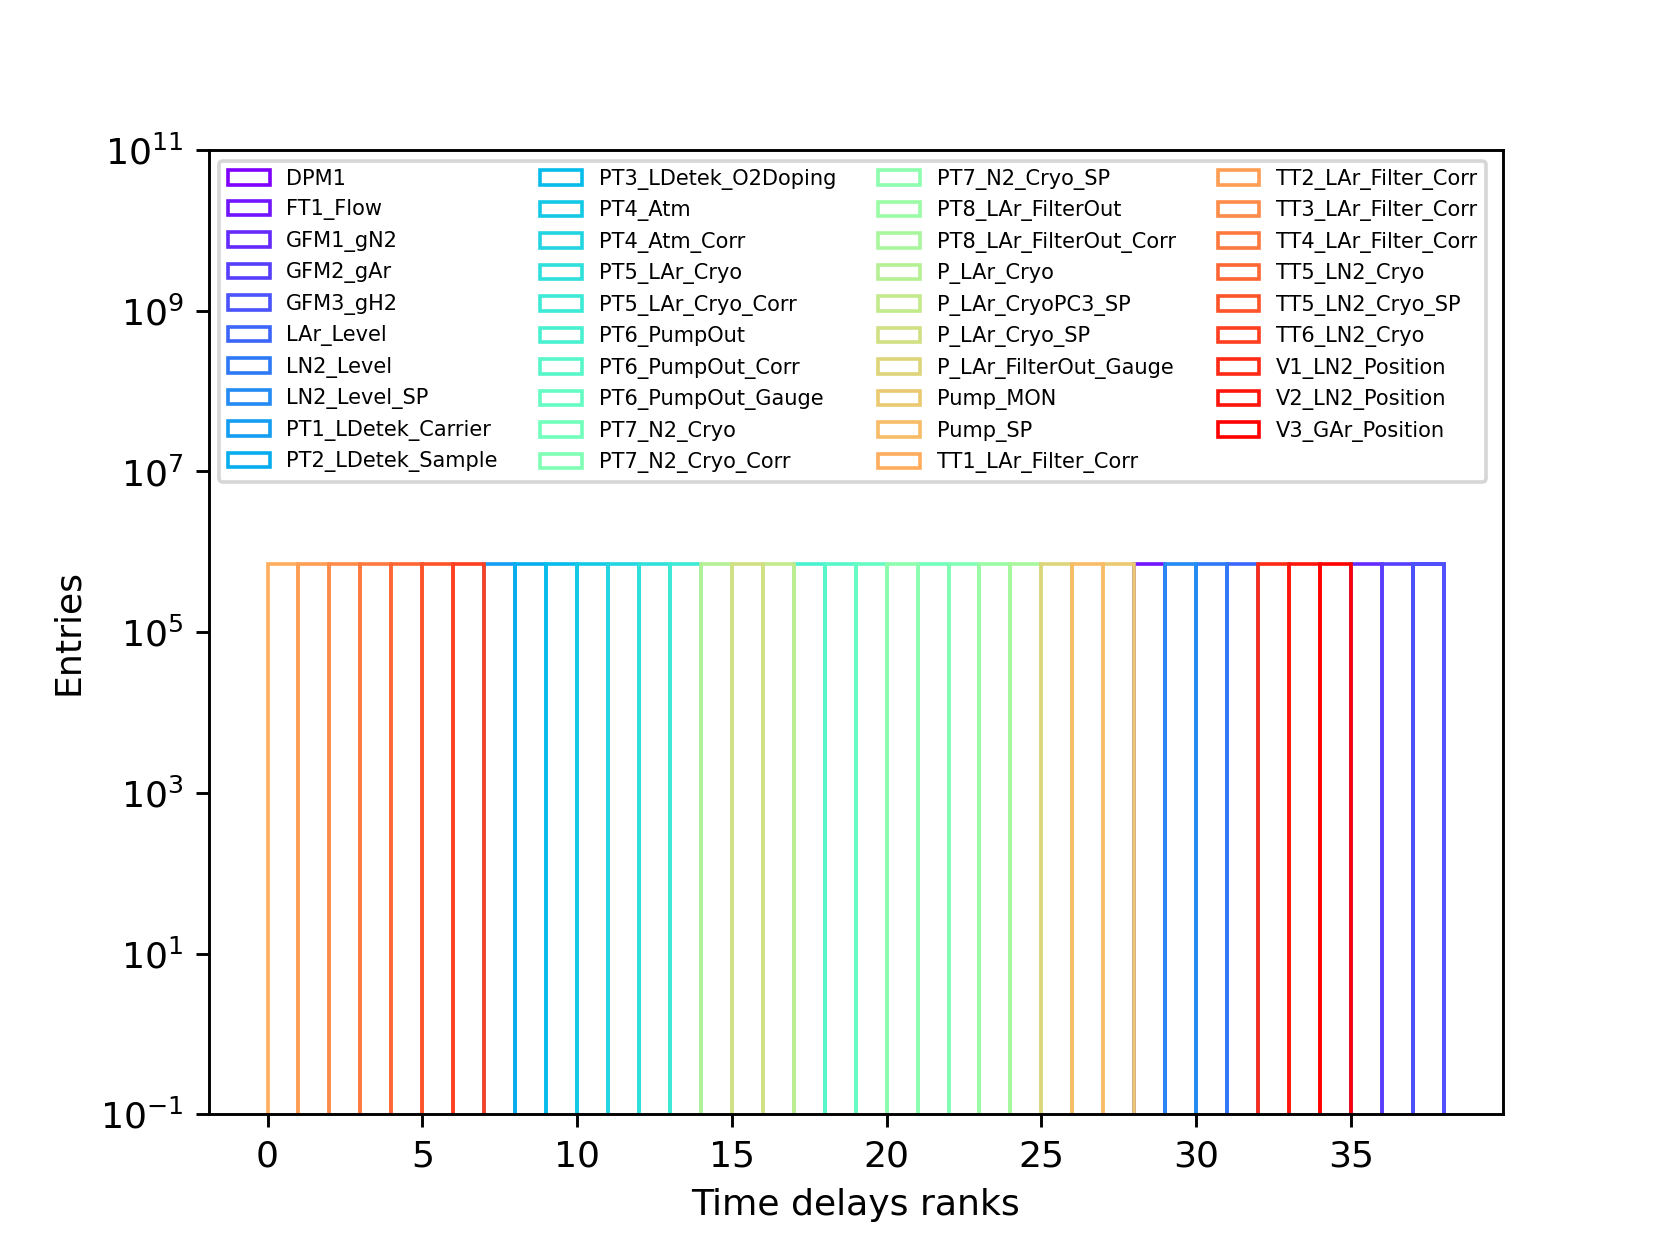

In [20]:
fig, axs = plt.subplots()

colr_map=matplotlib.cm.get_cmap('rainbow',len(list(utc_delta_df)))

for iDev in range(len(list(utc_delta_df))):
    dev = list(utc_delta_df)[iDev]
    delays_ranks_df[dev].plot.hist(bins=np.arange(len(list(delays_ranks_df))), edgecolor=colr_map(iDev), ax=axs, label=dev, histtype=u'step')
#
axs.set_xlabel('Time delays ranks')
axs.set_ylabel('Entries')
axs.set_ylim(0.1,1e11)#This is needed to fit the huge legend
axs.set_yscale('log')
axs.legend(fontsize='xx-small', ncol=4, loc='upper left')
fig.show()

The plot above shows that for what concers the mutual time delays between the different devices they always maintain the same ordering across all the observations (the table raws). If this was not the case I should have observed horizontal lines at lower entries than the maximum, while all the histograms have the same high (the total number of events) and consist of only 1 bin centred at a specific time delay rank.

From here it seems that each observation for each observation the devices are coherent. I will produce a preliminary root file with them, but more check are needed as other subleties might still be in there. A good way to figure this out better is to compare together the $\Delta t$ between consecutive observations for all the devices.

In [38]:
#Produce a root tree with the timestamp corresponding to the median timestamp of the utc times.
#First step is producing a dataframe
med_utcs_ser = utc_epocs_df.apply(np.median,axis=1)

<IPython.core.display.Javascript object>


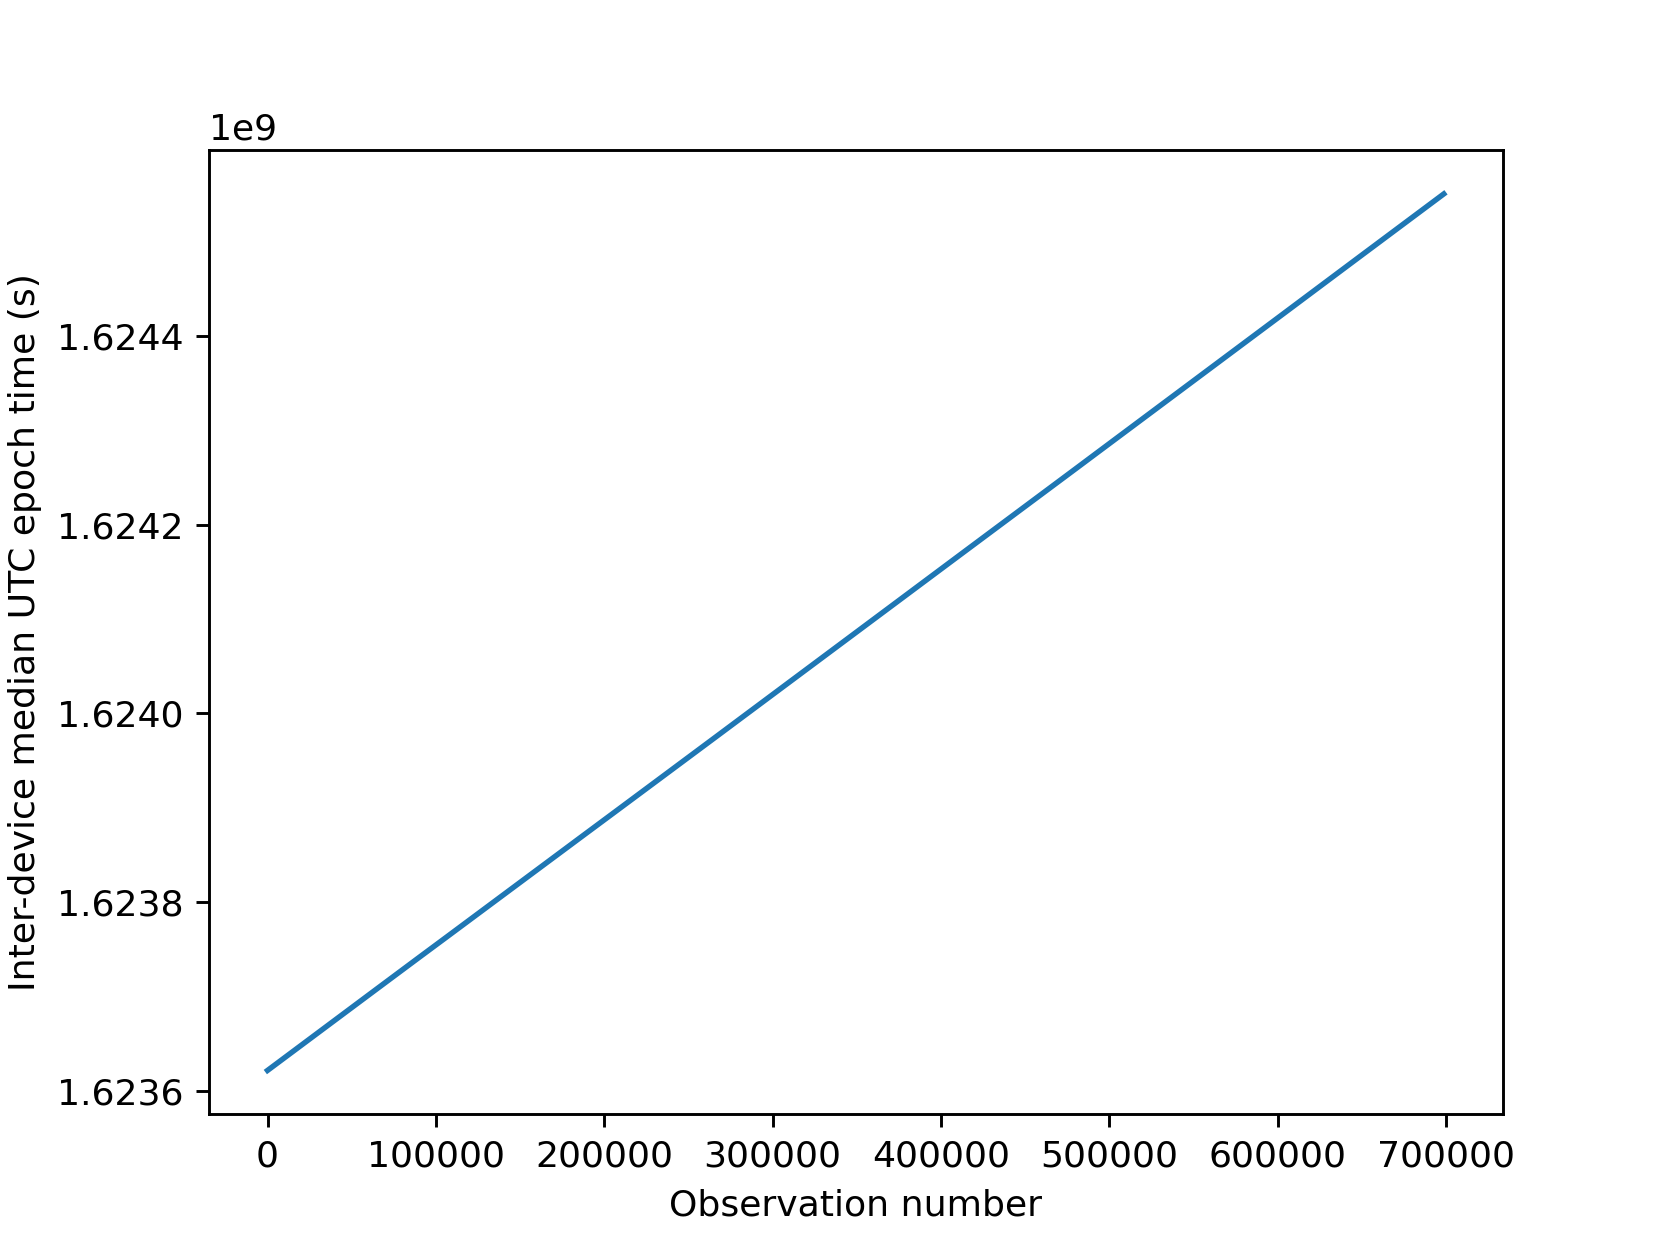

In [45]:
#Checking that what I have done makes sense
fig, axs = plt.subplots()

med_utcs_ser.plot(ax=axs)
#
axs.set_xlabel('Observation number')
axs.set_ylabel('Inter-device median UTC epoch time (s)')
fig.show()

In [49]:
#Make the tree data frame and the root tree
tree_df = pd.DataFrame()

#Round the UTC time stamp to msecs
tree_df['UTC'] = med_utcs_ser*1e3+0.5 #Convert the data to msec and 
tree_df['UTC'].apply(np.int64) #this makes the rounding to msec
#convert back to floating point (in seconds)
tree_df['UTC'] = tree_df['UTC']/1e3

for dev in devs_dfs:
    tree_df[dev] = devs_dfs[dev]['value']
#
tree_df.head(5).T

,0,1,2,3,4
UTC,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09,1.623622e+09
DPM1,1.030232e+02,1.029622e+02,1.029622e+02,1.030232e+02,1.029622e+02
FT1_Flow,-1.333351e-01,-6.826682e-01,-1.333351e-01,-6.826682e-01,-9.573350e-01
GFM1_gN2,8.398694e-01,6.955168e-01,8.398694e-01,7.086398e-01,7.086398e-01
GFM2_gAr,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GFM3_gH2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
LAr_Level,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
LN2_Level,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
LN2_Level_SP,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
PT1_LDetek_Carrier,7.163915e+00,7.163915e+00,7.163000e+00,7.163000e+00,7.164526e+00


In [58]:
#Save this preliminary tree into a rootfile
branches_types_dict = {}
branches_dict = {}

for col in list(tree_df):
    branches_dict[col] = tree_df[col].to_numpy()
    branches_types_dict[col] = branches_dict[col].dtype
#
with uproot3.recreate('data/SC_data_AllRun.root') as rootfile:
    rootfile['PLC_tree'] = uproot3.newtree(branches_types_dict, title='Data of the PLC devices')
    rootfile['PLC_tree'].extend(branches_dict)
#
    

In [14]:
#Plot maximum absolute delay times across the devices as function of observation number
utc_maxrange_arr = np.empty(utc_epochs_arr.shape[0])

for iRow in range(len(utc_maxrange_arr)):
    epochs_arr = utc_epochs_arr[iRow,:]
    utc_maxrange_arr[iRow] = epochs_arr.max() - epochs_arr.min()
#
utc_maxrange_ser = pd.Series(data=utc_maxrange_arr)
utc_maxrange_ser.to_frame().head(5)

,0
0,0.288364
1,0.279248
2,0.311537
3,0.299724
4,0.270735


Plotting the range (max - min) of UTC time for each observation.

<IPython.core.display.Javascript object>


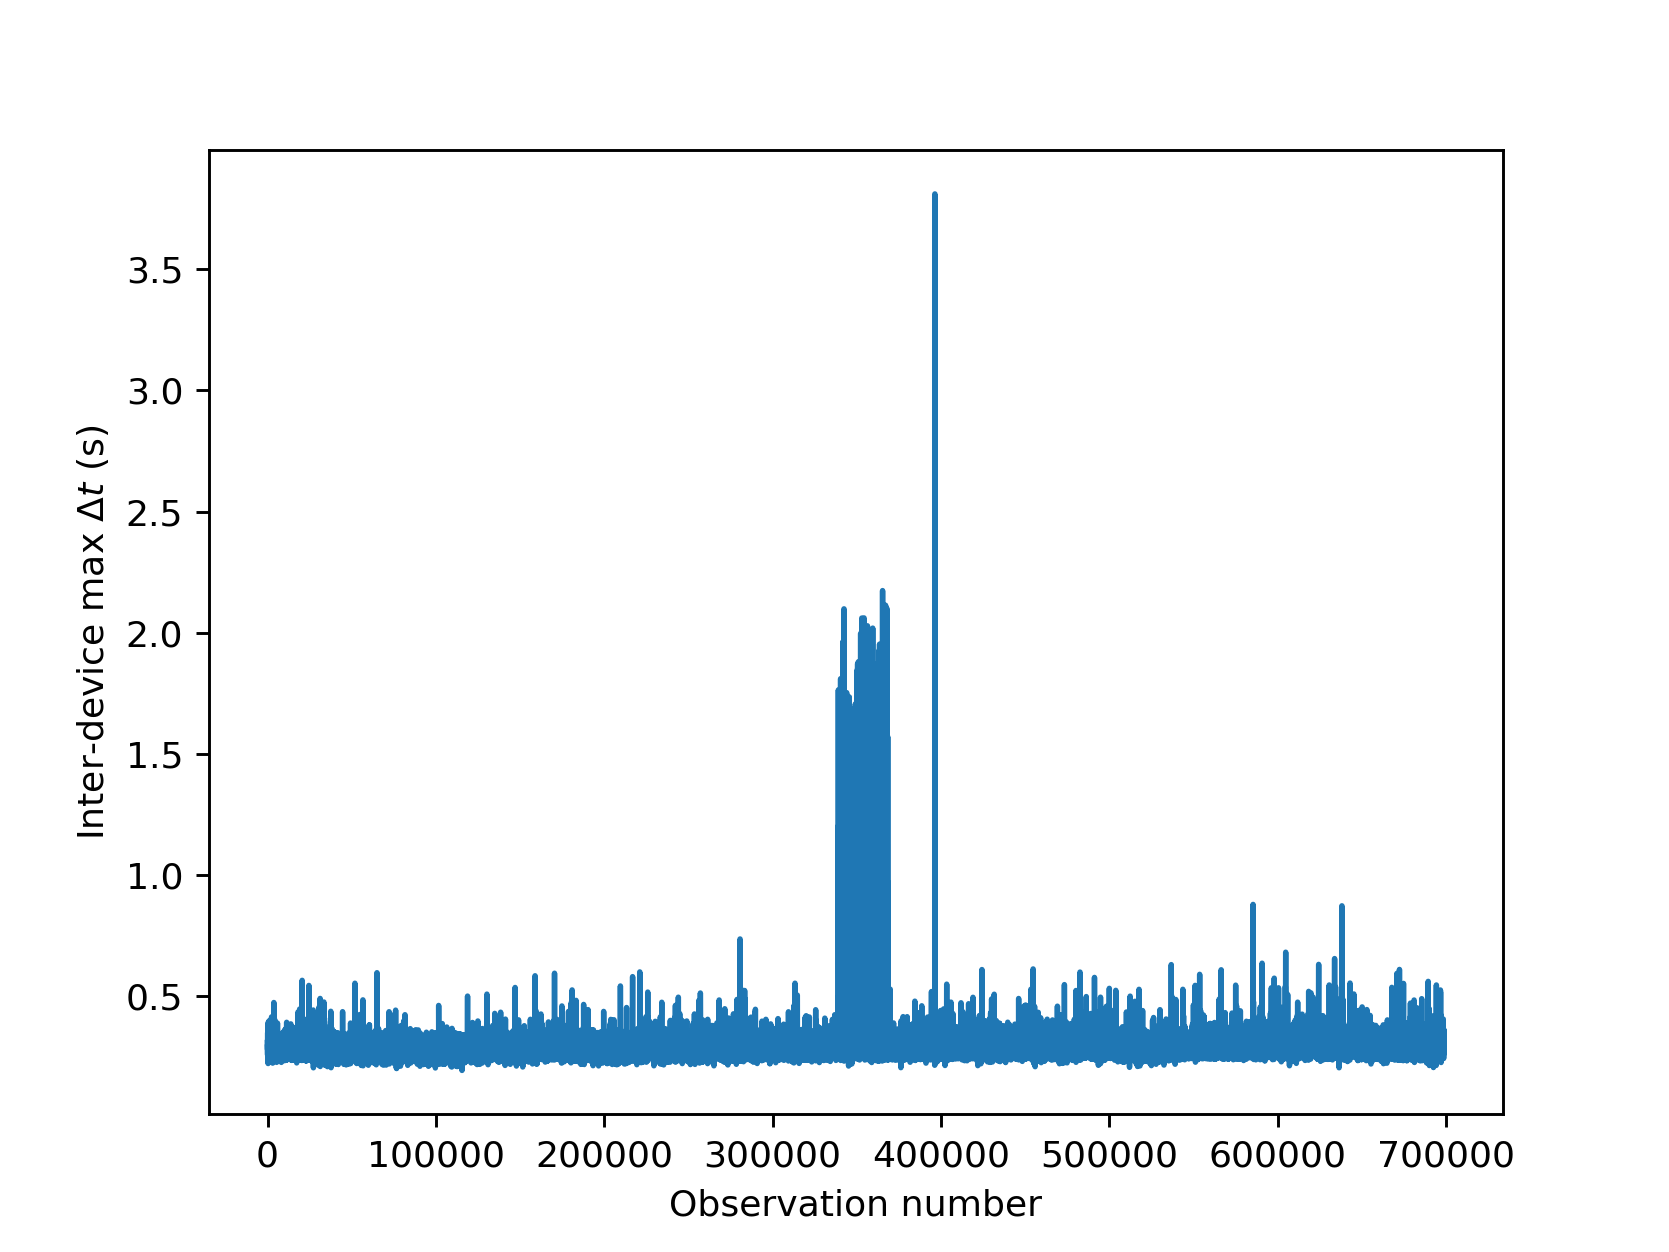

In [29]:
fig, axs = plt.subplots()

utc_maxrange_ser.plot(ax=axs)
#
axs.set_xlabel('Observation number')
axs.set_ylabel('Inter-device max $\Delta t$ (s)')
fig.show()

The plot above shows that most of the times the $\Delta t < 1\,\mathrm{s}$. However, there are observations where the maximum delay is quite long. This might hinder that not always the same observation consists of measurement devices measurements polled at the same time (almost considering network delays and program delay loops). I believe that time to time there are data packets, corresponding to measurements of different devices at the same time, that get randomly lost.

In [15]:
utc_delta_epochs_df = utc_epocs_df.diff().dropna()
utc_delta_epochs_df.head(5)

,DPM1,FT1_Flow,GFM1_gN2,GFM2_gAr,GFM3_gH2,LAr_Level,LN2_Level,LN2_Level_SP,PT1_LDetek_Carrier,PT2_LDetek_Sample,...,TT1_LAr_Filter_Corr,TT2_LAr_Filter_Corr,TT3_LAr_Filter_Corr,TT4_LAr_Filter_Corr,TT5_LN2_Cryo,TT5_LN2_Cryo_SP,TT6_LN2_Cryo,V1_LN2_Position,V2_LN2_Position,V3_GAr_Position
1,1.312851,1.313586,1.313680,1.313192,1.313474,1.312752,1.311735,1.311652,1.328837,1.328574,...,1.321967,1.326284,1.330067,1.330313,1.329959,1.329430,1.329169,1.312684,1.312785,1.313410
2,1.346494,1.339692,1.343183,1.343493,1.344686,1.339996,1.340452,1.340027,1.303163,1.302399,...,1.314205,1.312580,1.308862,1.308333,1.308157,1.304281,1.303806,1.339965,1.340480,1.342971
3,1.337840,1.337114,1.338613,1.338939,1.338659,1.338683,1.338378,1.337817,1.360207,1.360246,...,1.349653,1.346077,1.347322,1.347950,1.350275,1.359478,1.359388,1.338711,1.339191,1.338166
4,1.306278,1.315468,1.309583,1.308808,1.307461,1.314316,1.314909,1.315321,1.325244,1.325594,...,1.335267,1.336156,1.334621,1.333820,1.331838,1.323645,1.323696,1.313534,1.312608,1.310586
5,1.328378,1.327222,1.328128,1.327803,1.328404,1.327848,1.327367,1.326105,1.306443,1.306433,...,1.303042,1.302460,1.301610,1.300949,1.300070,1.305923,1.305358,1.328123,1.327845,1.328226


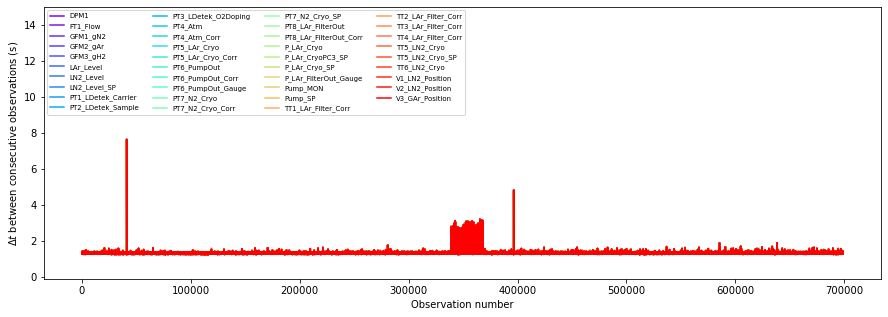

In [29]:
fig, axs = plt.subplots(figsize=(15,5))

colr_map=matplotlib.cm.get_cmap('rainbow',len(list(utc_delta_epochs_df)))

for iDev in range(len(list(utc_delta_df))):
    dev = list(utc_delta_epochs_df)[iDev]
    axs.plot(utc_delta_epochs_df[dev], label=dev, color=colr_map(iDev))
#
axs.set_xlabel('Observation number')
axs.set_ylabel('$\Delta t$ between consecutive observations (s)')
axs.set_ylim(-0.1,15)
axs.legend(fontsize='x-small', ncol=4, loc='upper left')
fig.show()

In the plot above the $\Delta t$ (UTC epoch times) between consecutive observations are compared together for all the devices. What emerges when zooming into the plots (execute the cell to do it) is a progressive loss of syncronisation. This occurs because measurement packets are lost individually in their pollings from the PLC or in their transmission to the InfluxDB server. This should be the cause of the mismatch across the devices of the $\Delta t$ of consecutive observationsand also the origin of different time series lenths.

In [31]:
!pwd


/mnt/data/ArCube/SingleModule_Jun2021
